# 5. Medallion Architecture

## 5.1. The Story: Building the Data Factory

Your e-commerce platform now has Delta Lake running. But there's chaos:
- 15 different notebooks, each loading data differently
- No naming conventions - `customers_v2_final_FINAL.csv` anyone?
- Data Scientists use Bronze data directly (with all the garbage)
- Finance dashboard shows different numbers than Marketing

**The CTO asks:** "Can we standardize this before we hire more engineers?"

**The Answer:** Medallion Architecture - a proven pattern used by Netflix, Uber, and thousands of companies.

---

## 5.2. Why Medallion? (The Engineering Case)

### The Pattern

](../../assets/images/vm6wbIWLjFG0fvwwftsOu.png)

### Why Three Layers? (Not Two, Not Five)

| Layers | Issue |
|--------|---------|
| **1 layer** | No separation of concerns, risky transformations on raw data |
| **2 layers** | "Where do we put validation?" - unclear ownership |
| **3 layers** | Clear responsibilities, testable boundaries |
| **5+ layers** | Over-engineering, increased latency, maintenance nightmare |

*Three layers hit the sweet spot for most organizations.*

### Layer Responsibilities

| Layer | Owner | SLA | Access |
|-------|-------|-----|--------|
| **Bronze** | Data Engineering | 15 min from source | Engineers only |
| **Silver** | Data Engineering | 1 hour from Bronze | Engineers + DS |
| **Gold** | Analytics Engineering | 4 hours from Silver | Everyone |


**Recommendation:** 
- Bronze: 90 days retention (or regulatory requirement)
- Silver: Indefinite (your master data)
- Gold: Depends on use case (often regenerated)

---

## 5.3. What You'll Build

| Layer | Tables | Transformations |
|-------|--------|-----------------|
| **Bronze** | customers, orders, products | Raw ingestion, metadata |
| **Silver** | customers, orders, products | Validation, dedup, typing |
| **Gold** | fact_sales, dim_customer, dim_product, dim_date | Star schema, SCD |

---

---

## 5.8. SCD Type 1 & Type 2

### 5.8.1. Goal

Understanding **Slowly Changing Dimensions** - how to track changes in dimensional data.

### 5.8.2. What is SCD (Slowly Changing Dimension)?

**Slowly Changing Dimension (SCD)** is a data warehousing concept describing how to handle changes in dimensional data.

### Example: Customer address change

Customer John Smith moved from Warsaw to Krakow. What do we do?

| Type | Strategy | Result |
|-----|-----------|----------|
| **SCD Type 0** | Retain original | Always Warsaw |
| **SCD Type 1** | Overwrite | Only Krakow |
| **SCD Type 2** | Track history | Both records with dates |
| **SCD Type 3** | Add column | `current_city=Krakow`, `previous_city=Warsaw` |

### 5.8.3. SCD Type 1 - Overwrite

### Characteristics:
- **Simplest** approach
- **No history** - old values are overwritten
- **Use cases:** Error corrections, data that don't require history


### Implementation in SQL (MERGE):
```sql
MERGE INTO dim_customer t
USING source_customers s
ON t.customer_id = s.customer_id
WHEN MATCHED THEN UPDATE SET *
WHEN NOT MATCHED THEN INSERT *
```

### 5.8.4. SCD Type 2 - Track History

### Characteristics:
- **Full history** of changes
- **Additional columns:** `__START_AT`, `__END_AT` (or `valid_from`, `valid_to`)
- **Use cases:** Audit, historical analysis, compliance


### 5.8.5. SCD Type 2 in Lakeflow - AUTO CDC

Databricks Lakeflow offers built-in support for SCD Type 2 through `AUTO CDC INTO`:

```sql
-- Creating target table SCD2
CREATE OR REFRESH STREAMING TABLE silver_customers (
  customer_id        STRING,
  first_name         STRING,
  last_name          STRING,
  city               STRING,
  -- SCD2 columns added automatically:
  __START_AT         TIMESTAMP,
  __END_AT           TIMESTAMP
);

-- Flow with AUTO CDC for SCD2
CREATE FLOW silver_customers_scd2_flow
AS AUTO CDC INTO silver_customers
FROM STREAM bronze_customers
KEYS (customer_id)         -- Business key
SEQUENCE BY ingestion_ts   -- Column determining the order
STORED AS SCD TYPE 2;      -- SCD Type
```

### Key elements:
- **KEYS** - columns identifying the business record
- **SEQUENCE BY** - column determining the order of changes
- **STORED AS SCD TYPE 1|2** - SCD type

### SCD Type 1 in Lakeflow:
```sql
CREATE FLOW silver_products_scd1_flow
AS AUTO CDC INTO silver_products
FROM bronze_products
KEYS (product_id)
SEQUENCE BY ingestion_ts
STORED AS SCD TYPE 1;  -- Overwrite without history
```

---

## 5.9. Lakeflow Pipelines - Declarations

### 5.9.1. Goal

Learning the syntax **Spark Declarative Pipelines** in SQL and PySpark - declarative way of defining data pipelines.

### 5.9.2. What is Lakeflow?

**Lakeflow** (formerly Delta Live Tables - DLT) is a Databricks framework for building declarative data pipelines.

### Declarative vs Imperative

| Approach | Example | Characteristics |
|-----------|----------|----------------|
| **Imperative** | `df.write.mode("overwrite")...` | You describe HOW |
| **Declarative** | `CREATE TABLE AS SELECT...` | You describe WHAT |

### Lakeflow Benefits:
- ✅ **Automatic dependency management** between tables
- ✅ **Built-in data quality** - constraints with actions
- ✅ **Unified batch/streaming** - same code
- ✅ **Automatic recovery** after failures
- ✅ **Lineage and monitoring** out-of-the-box
- ✅ **Incremental processing** - only new data

### 5.9.3. Table Types in Lakeflow

| Type | Usage | Characteristics |
|-----|--------|----------------|
| **STREAMING TABLE** | Data source, append-only | Processes only new data |
| **MATERIALIZED VIEW** | Aggregations, transformations | Always full recomputation |
| **VIEW** | Intermediate logic | Not materialized |

### 5.9.5. SQL: STREAMING TABLE with CONSTRAINTS (Silver)

```sql
CREATE OR REFRESH STREAMING TABLE silver_orders
(
  CONSTRAINT valid_order_id EXPECT (order_id IS NOT NULL)
    ON VIOLATION DROP ROW,
  CONSTRAINT valid_customer EXPECT (customer_id IS NOT NULL)
    ON VIOLATION DROP ROW,
  CONSTRAINT valid_quantity EXPECT (quantity > 0)
    ON VIOLATION DROP ROW,
  CONSTRAINT valid_price EXPECT (unit_price >= 0)
    ON VIOLATION FAIL UPDATE
)
AS
SELECT
  order_id,
  customer_id,
  product_id,
  CAST(order_datetime AS TIMESTAMP) AS order_ts,
  quantity,
  unit_price,
  (quantity * unit_price) AS gross_amount
FROM STREAM(bronze_orders);
```

### Actions for CONSTRAINTS:
- **`DROP ROW`** - remove invalid record
- **`FAIL UPDATE`** - fail the pipeline
- No action - log only

### 5.9.6. SQL: MATERIALIZED VIEW (Gold)

```sql
-- Dimension - current snapshot from SCD2
CREATE OR REFRESH MATERIALIZED VIEW dim_customer
AS
SELECT
  customer_id,
  first_name,
  last_name,
  email,
  city,
  customer_segment
FROM silver_customers
WHERE __END_AT IS NULL;

-- Date Dimension
CREATE OR REFRESH MATERIALIZED VIEW dim_date
AS
SELECT DISTINCT
  CAST(date_format(order_date, 'yyyyMMdd') AS INT) AS date_key,
  order_date AS date,
  year(order_date) AS year,
  quarter(order_date) AS quarter,
  month(order_date) AS month
FROM silver_orders;

-- Fact - streaming from Silver
CREATE OR REFRESH STREAMING TABLE fact_sales
AS
SELECT
  order_id,
  customer_id,
  product_id,
  order_date_key,
  quantity,
  gross_amount,
  net_amount
FROM STREAM(silver_orders);
```

### 5.9.7. What is FLOW?

**FLOW** is a Lakeflow mechanism that allows:
1. **Separation of table definition from data source**
2. **Multiple sources to one table** (e.g. backfill + streaming)
3. **CDC (Change Data Capture)** with automatic SCD

### FLOW Anatomy:

```sql
-- 1. We define empty target table
CREATE OR REFRESH STREAMING TABLE bronze_orders;

-- 2. We define FLOW(s) which populate it
CREATE FLOW flow_name
AS INSERT INTO target_table BY NAME
SELECT ... FROM source;
```

### 5.9.8. FLOW: Backfill + Streaming Pattern

```sql
-- Target table
CREATE OR REFRESH STREAMING TABLE bronze_orders;

-- FLOW 1: One-time backfill
CREATE FLOW bronze_orders_backfill
AS 
INSERT INTO ONCE bronze_orders BY NAME
SELECT
  order_id,
  customer_id,
  product_id,
  order_datetime,
  'batch' AS source_system,
  _metadata.file_path AS source_file_path,
  current_timestamp() AS load_ts
FROM read_files(
  '${order_path}/orders_batch.json',
  format => 'json'
);

-- FLOW 2: Continuous streaming
CREATE FLOW bronze_orders_stream
AS 
INSERT INTO bronze_orders BY NAME
SELECT
  order_id,
  customer_id,
  'stream' AS source_system,
  _metadata.file_path AS source_file_path,
  current_timestamp() AS load_ts
FROM STREAM read_files(
  '${order_path}/stream/orders_stream_*.json',
  format => 'json'
);
```

### Key elements:
- **`INSERT INTO ONCE`** - execute once (backfill)
- **`INSERT INTO`** - continuous insertion (streaming)
- **`BY NAME`** - column mapping by name

### 5.9.9. FLOW: AUTO CDC for SCD Type 2

```sql
-- SCD2 Table with schema
CREATE OR REFRESH STREAMING TABLE silver_customers (
  customer_id        STRING,
  first_name         STRING,
  last_name          STRING,
  email              STRING,
  city               STRING,
  __START_AT         TIMESTAMP,
  __END_AT           TIMESTAMP
);

-- AUTO CDC Flow
CREATE FLOW silver_customers_scd2_flow
AS AUTO CDC INTO silver_customers
FROM STREAM bronze_customers
KEYS (customer_id)
SEQUENCE BY ingestion_ts
STORED AS SCD TYPE 2;
```

### What does AUTO CDC do?
1. Compares new records with existing by `KEYS`
2. Detects changes in columns
3. For SCD2: closes old record (`__END_AT`), inserts new
4. For SCD1: overwrites existing record

### 5.9.10. PySpark Declarations

```python
from pyspark import pipelines as dp
from pyspark.sql.functions import *

# STREAMING TABLE
@dp.table(
    name="bronze_customers",
    comment="Raw customers from CSV"
)
def bronze_customers():
    return (
        spark.readStream
            .format("cloudFiles")
            .option("cloudFiles.format", "csv")
            .option("header", "true")
            .load(spark.conf.get("customer_path"))
            .select(
                "*",
                "_metadata.file_path".alias("source_file_path"),
                current_timestamp().alias("load_ts")
            )
    )

# MATERIALIZED VIEW
@dp.table(name="dim_customer")
def dim_customer():
    return (
        spark.read.table("silver_customers")
            .filter(col("__END_AT").isNull())
            .select("customer_id", "first_name", "last_name")
    )
```

### 5.9.11. PySpark: Expectations (Constraints)

```python
@dp.table(name="silver_orders")
@dp.expect_or_drop("valid_order_id", "order_id IS NOT NULL")
@dp.expect_or_drop("valid_customer", "customer_id IS NOT NULL")
@dp.expect_or_drop("valid_quantity", "quantity > 0")
@dp.expect_or_fail("valid_price", "unit_price >= 0")
def silver_orders():
    return (
        spark.readStream.table("bronze_orders")
            .select(
                "order_id",
                "customer_id",
                col("order_datetime").cast("timestamp").alias("order_ts"),
                (col("quantity") * col("unit_price")).alias("gross_amount")
            )
    )
```

### Expectations Decorators:
- **`@dp.expect`** - log only
- **`@dp.expect_or_drop`** - drop the record
- **`@dp.expect_or_fail`** - fail the pipeline

### 5.9.12. PySpark: apply_changes (CDC)

```python
from pyspark import pipelines as dp

# Define the target table
dp.create_streaming_table(
    name="silver_customers",
    schema="""
        customer_id STRING,
        first_name STRING,
        city STRING,
        __START_AT TIMESTAMP,
        __END_AT TIMESTAMP
    """
)

# Define the CDC flow
dp.create_auto_cdc_flow(
    target="silver_customers",
    source="bronze_customers",
    keys=["customer_id"],
    sequence_by="ingestion_ts",
    stored_as_scd_type=2  # or 1
)
```

---

## 5.10. DEMO - Building the Pipeline

### 5.10.1. Goal

Practical construction of a Lakeflow pipeline step-by-step in Databricks.

### 5.10.2. SQL Files Overview

Our pipeline consists of SQL files in folder `lakeflow/`:

```
lakeflow/
├── 01_bronze/
│   ├── bronze_customers.sql
│   ├── bronze_orders.sql
│   └── bronze_products.sql
├── 02_silver/
│   ├── silver_customers.sql
│   ├── silver_orders.sql
│   └── silver_products.sql
└── 03_gold/
    ├── dim_customer.sql
    ├── dim_date.sql
    ├── dim_payment_method.sql
    ├── dim_product.sql
    ├── dim_store.sql
    └── fact_sales.sql
```

### 5.10.3. Step 1: Upload SQL Files

### Option A: Via UI
1. Databricks → Workspace → Users → (your folder)
2. Create folder `lakeflow_pipeline`
3. Upload SQL files from folder `lakeflow/`

### Option B: Via Repos
1. Databricks → Repos → Add Repo
2. Clone training repository

### 5.10.4. Step 2: Create Pipeline

1. Go to **Workflows** → **Jobs & Pipelines** (1)
2. Click **Create ETL Pipeline** (2)

![!\[Zrzut ekranu 2025-12-8 o 20.39.11.png\](<attachment:Zrzut ekranu 2025-12-8 o 20.39.11.png>)](<../../assets/images/Zrzut ekranu 2025-12-8 o 20.39.11.png>)


3. Fill in details:
- **Choose your CATALOG** ecommerce_platform_<your_name>
- **Pipeline Name:** `lakeflow_pipeline_<your_name>`

![!\[!\\[Zrzut ekranu 2025-12-8 o 20.43.57.png\\](<attachment:Zrzut ekranu 2025-12-8 o 20.43.57.png>)\](<../../assets/images/Zrzut ekranu 2025-12-8 o 20.43.57.png>)](<../../assets/images/Zrzut ekranu 2025-12-8 o 21.28.08.png>)


- **Target Schema:** `<your_name>_lakeflow`

![!\[Zrzut ekranu 2025-12-8 o 20.45.54.png\](<attachment:Zrzut ekranu 2025-12-8 o 20.45.54.png>)](<../../assets/images/Zrzut ekranu 2025-12-8 o 20.45.54.png>)



- **Source Code:**  Choose Add existing assets 


- **Choose pipeline root folder** /Workspace/User/<your_name>/DatabricksDataEngineerOne/lakeflow/lakeflow_trn_pipeline

- **Choose source code folder** /Workspace/User/<your_name>/DatabricksDataEngineerOne/lakeflow/lakeflow_trn_pipeline/transformations


![!\[Zrzut ekranu 2025-12-8 o 21.32.14.png\](<attachment:Zrzut ekranu 2025-12-8 o 21.32.14.png>)](<../../assets/images/Zrzut ekranu 2025-12-8 o 21.32.14.png>)




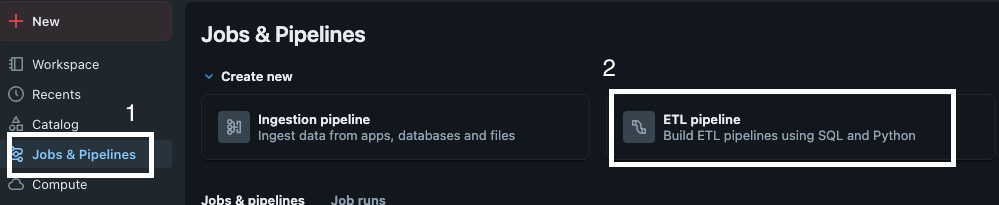
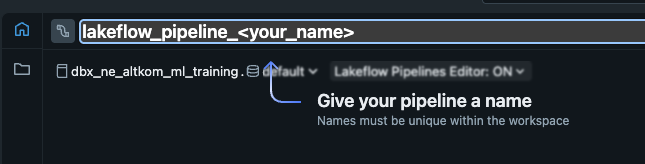
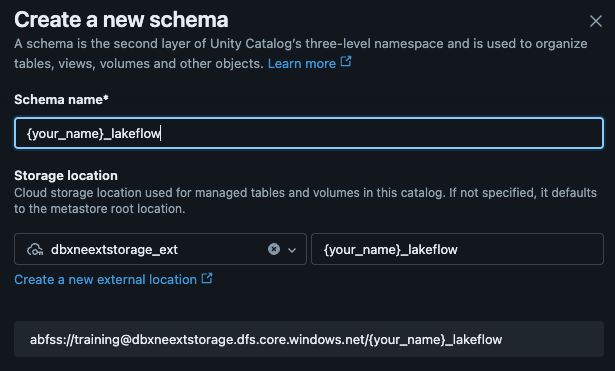

![Pipeline Source Configuration View](<../../assets/images/Zrzut ekranu 2025-12-8 o 21.34.39.png>)

### 5.10.5. Step 3: Configure Variables

 **Configuration** → **Add configuration**:

| Key | Value |
|-----|-------|
| `customer_path` | `/Volumes/<your catalog>/default/datasets/customers` |
| `order_path` | `/Volumes/<your catalog>//default/datasets/orders` |
| `product_path` | `/Volumes/<your catalog>/default/datasets/products/products.parquet/` |

Open settings and go to Pipeline Configuration 

![Opening Pipeline Settings](<../../assets/images/Zrzut ekranu 2025-12-8 o 21.35.55.png>)

Add configuration : 

![Adding Pipeline Configuration Parameters](<../../assets/images/Zrzut ekranu 2025-12-8 o 21.38.05.png>)

Add cluster configuration

![Cluster Configuration](<../../assets/images/Zrzut ekranu 2025-12-8 o 21.40.24.png>)
"""))


Click **Dry Run** - check syntax and DAG





![Validating Pipeline (Dry Run)](<../../assets/images/Zrzut ekranu 2025-12-8 o 21.59.58.png>)


You should also see a DAG diagram built based on Spark Declarative Pipelines definition

![Pipeline DAG Diagram](<../../assets/images/Zrzut ekranu 2025-12-8 o 22.08.21.png>)


![Pipeline Execution Progress](<../../assets/images/Zrzut ekranu 2025-12-8 o 22.10.32.png>)

1. Add new file to folder orders/stream/
2. Run pipeline again
3. Check Event Log - should process only new files

If you click schedule button on top right corner then you will be able to schedule that job based on trigger mode:

![Scheduling the Pipeline](<../../assets/images/Zrzut ekranu 2025-12-8 o 22.14.30.png>)

### 5.10.7. Step 5: Verify Results

In [ ]:
# Check fact_sales with joins to dimensions
display(spark.sql(f"""
    SELECT 
        f.order_id,
        c.first_name || ' ' || c.last_name AS customer_name,
        p.product_name,
        d.date,
        f.quantity,
        f.net_amount
    FROM {catalog_name}.{user_schema}_lakeflow.fact_sales f
    LEFT JOIN {catalog_name}.{user_schema}_lakeflow.dim_customer c ON f.customer_id = c.customer_id
    LEFT JOIN {catalog_name}.{user_schema}_lakeflow.dim_product p ON f.product_id = p.product_id
    LEFT JOIN {catalog_name}.{user_schema}_lakeflow.dim_date d ON f.order_date_key = d.date_key
    LIMIT 10
"""))


In [ ]:
# Znajdź klientów z historią zmian
display(spark.sql(f"""
    SELECT 
        customer_id, first_name, city,
        __START_AT, __END_AT,
        CASE WHEN __END_AT IS NULL THEN 'Current' ELSE 'Historical' END AS status
    FROM {catalog_name}.{user_schema}_lakeflow.silver_customers
    WHERE customer_id IN (
        SELECT customer_id 
        FROM {catalog_name}.{user_schema}_lakeflow.silver_customers 
        GROUP BY customer_id HAVING COUNT(*) > 1
    )
    ORDER BY customer_id, __START_AT
"""))

### 5.10.10. Monitoring and Troubleshooting

### Event Log
- Click on table in DAG → processing details
- Metrics: records processed, dropped rows, duration

### Common issues:

| Issue | Cause | Solution |
|---------|-----------|-------------|
| Pipeline hangs | Cluster too small | Increase min workers |
| Missing data | Constraint DROP ROW | Check Data Quality tab |
| Schema mismatch | Schema change | Full refresh |

---

## 5.11. Summary

### 5.11.1. Key Takeaways

### Medallion Architecture
- **Bronze:** Raw data + metadata
- **Silver:** Cleaned, validated
- **Gold:** Business-ready, star schema

### SCD Types
- **SCD Type 1:** Overwrite - no history
- **SCD Type 2:** Track history - `__START_AT`, `__END_AT`

### Lakeflow Declarations
- **STREAMING TABLE:** Data append-only
- **MATERIALIZED VIEW:** Aggregations
- **FLOW:** CDC, backfill+streaming

### Best Practices
1. Constraints with `DROP ROW` for quality
2. Backfill (ONCE) + streaming FLOWs
3. SCD Type 2 for dimensions with history
4. STREAMING TABLE for facts

### 5.11.2. Resources

- [Databricks Lakeflow Docs](https://docs.databricks.com/en/delta-live-tables/index.html)
- [Medallion Architecture](https://www.databricks.com/glossary/medallion-architecture)
- [SCD with Lakeflow](https://docs.databricks.com/en/delta-live-tables/cdc.html)